In [ ]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
import joblib
from lib.loader import SingleFileExtractor, FolderExtractor, Segment
from scipy.signal import savgol_filter
import tensorflow as tf
import scipy.signal as ss

In [ ]:
# Parametry
HDF_PATH = "data"
SIGNAL_NAME = "art"
WINDOW_SIZE = 500
BATCH_SIZE = 64
LATENT_DIM = 8
EPOCHS = 10
BETA = 1e-3
MODEL_DIR = "models"
MAX_SAMPLES = 36000
os.makedirs(MODEL_DIR, exist_ok=True)

In [ ]:
class CreathonSegmentSequence(Sequence):
    def __init__(self, segments, window_size=500, batch_size=64, normalize=True):
        self.window_size = window_size
        self.batch_size = batch_size
        self.normalize = normalize
        self.windows = []
        self.data_mean = None
        self.data_std = None

        all_data = np.concatenate([seg.data for seg in segments if seg.data is not None and len(seg.data) >= window_size])
        self.data_mean = np.nanmean(all_data)
        self.data_std = np.nanstd(all_data) + 1e-8

        for seg in segments:
            if seg.data is None or len(seg.data) < window_size:
                continue
            data = seg.data
            if normalize:
                data = (data - self.data_mean) / self.data_std
            for i in range(len(data) - window_size + 1):
                window = data[i:i + window_size]
                if np.isnan(window).any():
                    continue
                self.windows.append(window)

        self.windows = np.array(self.windows)[..., np.newaxis]

    def __len__(self):
        return len(self.windows) // self.batch_size

    def __getitem__(self, idx):
        batch = self.windows[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch, batch

def get_file_paths(folder_path):
    folder_extractor = FolderExtractor(folder_path)
    return [e._hdf5_file_path for e in folder_extractor._extractors]

def load_sequence_from_single_file(file_path, annotations_path, signal_name="icp",
                                   window_size=500, batch_size=64, use_anomalous=False):
    extractor = SingleFileExtractor(file_path)
    extractor.auto_annotate(annotations_path)

    good, anom = extractor.extract(signal_name)
    segments = good + anom if use_anomalous else good

    limited_segments = []
    total_samples = 0
    for seg in segments:
        if seg.data is None:
            continue
        if total_samples >= MAX_SAMPLES:
            break
        seg_length = len(seg.data)
        if total_samples + seg_length > MAX_SAMPLES:
            seg.data = seg.data[:MAX_SAMPLES - total_samples]
        limited_segments.append(seg)
        total_samples += len(seg.data)

    extractor.load_data(limited_segments)
    return CreathonSegmentSequence(limited_segments, window_size, batch_size)


In [ ]:

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_encoder(latent_dim):
    inputs = layers.Input(shape=(WINDOW_SIZE, 1))
    x = layers.Conv1D(16, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(32, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu")(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    z = Sampling()([z_mean, z_log_var])
    return Model(inputs, [z_mean, z_log_var, z], name="encoder")

def build_decoder(latent_dim):
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(500, activation="relu")(inputs)
    x = layers.Reshape((500, 1))(x)
    x = layers.Conv1D(64, 3, padding="same", activation="relu")(x)
    x = layers.Conv1D(32, 3, padding="same", activation="relu")(x)
    x = layers.Conv1D(16, 3, padding="same", activation="relu")(x)
    x = layers.Conv1D(1, 3, padding="same", activation="linear")(x)
    return Model(inputs, x, name="decoder")

class VAE(Model):
    def __init__(self, encoder, decoder, beta=1e-3):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            recon_loss = tf.reduce_mean(tf.square(data - reconstruction))
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = recon_loss + self.beta * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [ ]:
encoder = build_encoder(LATENT_DIM)
decoder = build_decoder(LATENT_DIM)
vae = VAE(encoder, decoder, beta=BETA)
vae.compile(optimizer=tf.keras.optimizers.Adam(1e-3))

last_sequence = None

all_files = get_file_paths(HDF_PATH)
if all_files:
    file_path = all_files[0]
    print(f"Trénuji na prvním souboru: {os.path.basename(file_path)}")
    sequence = load_sequence_from_single_file(
        file_path=file_path,
        annotations_path=HDF_PATH,
        signal_name=SIGNAL_NAME,
        window_size=WINDOW_SIZE,
        batch_size=BATCH_SIZE,
        use_anomalous=False
    )
    if len(sequence) > 0:
        vae.fit(sequence, epochs=EPOCHS)
        last_sequence = sequence

encoder.save(os.path.join(MODEL_DIR, "vae_encoder_2.keras"))
decoder.save(os.path.join(MODEL_DIR, "vae_decoder_2.keras"))

In [ ]:
def plot_generation(n_samples=3):
    random_latents = tf.random.normal((n_samples, LATENT_DIM))
    generated = vae.decoder(random_latents).numpy()
    if last_sequence:
        generated = generated * last_sequence.data_std + last_sequence.data_mean

    plt.figure(figsize=(10, 2))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.plot(generated[i].squeeze())
        plt.title(f"Sample {i+1}")
    plt.tight_layout()
    plt.show()

def plot_reconstruction():
    if not last_sequence:
        print("Nebyla nalezena žádná trénovací sekvence.")
        return
    X, _ = last_sequence[0]
    recon = vae.decoder(vae.encoder(X)[2]).numpy()
    X = X * last_sequence.data_std + last_sequence.data_mean
    recon = recon * last_sequence.data_std + last_sequence.data_mean

    plt.figure(figsize=(10, 4))
    for i in range(3):
        plt.subplot(3, 2, i * 2 + 1)
        plt.plot(X[i].squeeze(), label="Original")
        plt.legend()
        plt.subplot(3, 2, i * 2 + 2)
        plt.plot(recon[i].squeeze(), label="Reconstruction")
        plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
plot_reconstruction()
plot_generation(3)

In [ ]:
random_latents = tf.random.normal((3, LATENT_DIM))
print(random_latents)
generated = vae.decoder(random_latents).numpy()
generated = generated * last_sequence.data_std + last_sequence.data_mean

plt.plot(generated[0].squeeze())
plt.show()
plt.plot(savgol_filter(generated[0].squeeze(), 9, 3))
plt.show()

In [ ]:
encoder = load_model("models/vae_encoder_hour.keras", compile=False, custom_objects={"Sampling": Sampling})
decoder = load_model("models/vae_decoder_hour.keras", compile=False)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def reconstruct_from_partial_fft(signal, keep=25):
    """
    Vstup:
        signal - 1D pole, reálný signál
        keep - počet nízkofrekvenčních složek, které si chceme ponechat

    Výstup:
        reconstructed - rekonstruovaný signál z částečného spektra
        fft_full - původní spektrum
        fft_trimmed - oříznuté spektrum
    """
    L = len(signal)
    fft_full = np.fft.fft(signal)

    # Zachovej jen N složek (bez střední a koncové harmonické)
    fft_trimmed = fft_full[:keep].copy()

    # Zrekonstruuj symetrické spektrum (Hermitovské – pro reálný časový signál)
    fft_new = np.zeros(L, dtype=complex)
    fft_new[:keep] = fft_trimmed
    fft_new[-keep+1:] = np.conj(fft_trimmed[1:][::-1])

    reconstructed = np.fft.ifft(fft_new)
    return reconstructed.real, fft_full, fft_trimmed


file_path = all_files[0]
sequence = load_sequence_from_single_file(
    file_path=file_path,
    annotations_path=HDF_PATH,
    signal_name=SIGNAL_NAME,
    window_size=WINDOW_SIZE,
    batch_size=BATCH_SIZE,
    use_anomalous=False
)

original_signal = sequence.windows[0].squeeze()
reconstructed, fft_full, fft_cut = reconstruct_from_partial_fft(original_signal, keep=16)

plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(np.abs(fft_full), label="Full FFT magnitude")
plt.title("Spektrum původního signálu")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(np.abs(fft_cut), label="Oříznutých 15 složek")
plt.title("Zkrácené spektrum")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(original_signal, label="Originál")
plt.title("Originální signál")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(reconstructed, label="Rekonstruovaný z FFT (15)", color="orange")
plt.title("Rekonstruovaný signál z oříznutého spektra")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
from lib.loader import SingleFileExtractor, FolderExtractor, Segment

HDF_PATH = "data"
SIGNAL_NAME = "art"
WINDOW_SIZE = 500
OUTPUT_HDF5 = "spectrum/spectra_analysis.hdf5"
N_COMPONENTS = 100

def get_file_paths(folder_path):
    folder_extractor = FolderExtractor(folder_path)
    return [e._hdf5_file_path for e in folder_extractor._extractors]

def load_signal(file_path, annotations_path, signal_name="art"):
    extractor = SingleFileExtractor(file_path)
    extractor.auto_annotate(annotations_path)
    segments, _ = extractor.extract(signal_name)
    extractor.load_data(segments)
    all_data = np.concatenate([seg.data for seg in segments if seg.data is not None])
    return all_data

def compute_spectra(signal, window_size=500, n_components=16):
    spectra = []
    for i in range(0, len(signal) - window_size + 1, window_size):
        window = signal[i:i + window_size]
        if not np.isnan(window).any():
            fft_vals = np.fft.fft(window)
            spectrum = np.abs(fft_vals[:n_components])
            spectra.append(spectrum)
    return np.array(spectra)

all_files = get_file_paths(HDF_PATH)
if not all_files:
    raise FileNotFoundError("Nebyl nalezen žádný HDF5 soubor v cílové složce.")

output_dir = os.path.dirname(OUTPUT_HDF5) or "."
os.makedirs(output_dir, exist_ok=True)

with h5py.File(OUTPUT_HDF5, "w") as f:
    for file_path in all_files:
        print(f"Zpracovávám: {os.path.basename(file_path)}")
        try:
            signal = load_signal(file_path, HDF_PATH, SIGNAL_NAME)
            spectra = compute_spectra(signal, window_size=WINDOW_SIZE, n_components=N_COMPONENTS)
            dataset_name = os.path.splitext(os.path.basename(file_path))[0]
            f.create_dataset(dataset_name, data=spectra, dtype="float32")
        except Exception as e:
            print(f"Chyba při zpracování {file_path}: {e}")

print(f"Spektrální analýza dokončena. Výsledky uloženy v {OUTPUT_HDF5}.")


In [ ]:
def inspect_hdf5_structure(hdf5_path):
    with h5py.File(hdf5_path, "r") as f:
        print("\nStruktura HDF5 souboru:")
        def print_structure(name, obj):
            if isinstance(obj, h5py.Dataset):
                print(f"- Dataset: {name}, shape={obj.shape}, dtype={obj.dtype}")
            elif isinstance(obj, h5py.Group):
                print(f"- Group: {name}")
        f.visititems(print_structure)

        print("\nUkázka hodnot z prvního datasetu:")
        first_key = list(f.keys())[0]
        print(f"→ Dataset: {first_key}")
        print(f[first_key][:5])

inspect_hdf5_structure(OUTPUT_HDF5)

In [ ]:
def reconstruct_signals_from_spectra(hdf5_path, n=4, window_size=500):
    with h5py.File(hdf5_path, "r") as f:
        first_key = list(f.keys())[0]
        spectra = f[first_key][:n]

    reconstructed_signals = []
    for spectrum in spectra:
        full_spectrum = np.zeros(window_size, dtype=complex)
        full_spectrum[:len(spectrum)] = spectrum
        full_spectrum[-len(spectrum)+1:] = np.conj(spectrum[1:][::-1])
        signal = np.fft.ifft(full_spectrum).real
        reconstructed_signals.append(signal)

    plt.figure(figsize=(12, 6))
    for i, signal in enumerate(reconstructed_signals):
        plt.subplot(n, 1, i+1)
        plt.plot(signal)
        plt.title(f"Rekonstruovaný signál {i+1}")
    plt.tight_layout()
    plt.show()

reconstruct_signals_from_spectra(OUTPUT_HDF5, n=4, window_size=WINDOW_SIZE)

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
from lib.loader import SingleFileExtractor, FolderExtractor, Segment

HDF_PATH = "data"
SIGNAL_NAME = "art"
WINDOW_SIZE = 500
OUTPUT_HDF5 = "spectrum/spectra_analysis.hdf5"
N_COMPONENTS = 16

def get_file_paths(folder_path):
    folder_extractor = FolderExtractor(folder_path)
    return [e._hdf5_file_path for e in folder_extractor._extractors]

def load_signal(file_path, annotations_path, signal_name="art"):
    extractor = SingleFileExtractor(file_path)
    extractor.auto_annotate(annotations_path)
    segments, _ = extractor.extract(signal_name)
    extractor.load_data(segments)
    all_data = np.concatenate([seg.data for seg in segments if seg.data is not None])
    return all_data

def compute_spectra(signal, window_size=500, n_components=16):
    spectra = []
    for i in range(0, len(signal) - window_size + 1, window_size):
        window = signal[i:i + window_size]
        if not np.isnan(window).any():
            fft_vals = np.fft.fft(window)
            fft_cut = fft_vals[:n_components].copy()
            full_spectrum = np.zeros(window_size, dtype=complex)
            full_spectrum[:n_components] = fft_cut
            full_spectrum[-n_components+1:] = np.conj(fft_cut[1:][::-1])
            spectra.append((window.copy(), full_spectrum))
    return spectra

all_files = get_file_paths(HDF_PATH)
if not all_files:
    raise FileNotFoundError("Nebyl nalezen žádný HDF5 soubor v cílové složce.")

output_dir = os.path.dirname(OUTPUT_HDF5) or "."
os.makedirs(output_dir, exist_ok=True)

with h5py.File(OUTPUT_HDF5, "w") as f:
    for file_path in all_files:
        print(f"Zpracovávám: {os.path.basename(file_path)}")
        try:
            signal = load_signal(file_path, HDF_PATH, SIGNAL_NAME)
            spectra_data = compute_spectra(signal, window_size=WINDOW_SIZE, n_components=N_COMPONENTS)
            dataset_name = os.path.splitext(os.path.basename(file_path))[0]
            original_windows = np.array([pair[0] for pair in spectra_data])
            spectra = np.array([pair[1] for pair in spectra_data])
            grp = f.create_group(dataset_name)
            grp.create_dataset("original", data=original_windows, dtype="float32")
            grp.create_dataset("spectra", data=spectra, dtype="complex64")
        except Exception as e:
            print(f"Chyba při zpracování {file_path}: {e}")

print(f"Spektrální analýza dokončena. Výsledky uloženy v {OUTPUT_HDF5}.")

def inspect_hdf5_structure(hdf5_path):
    with h5py.File(hdf5_path, "r") as f:
        print("\nStruktura HDF5 souboru:")
        def print_structure(name, obj):
            if isinstance(obj, h5py.Dataset):
                print(f"- Dataset: {name}, shape={obj.shape}, dtype={obj.dtype}")
            elif isinstance(obj, h5py.Group):
                print(f"- Group: {name}")
        f.visititems(print_structure)

        print("\nUkázka hodnot z prvního datasetu:")
        first_group = list(f.keys())[0]
        print(f"→ Group: {first_group}")
        print("Original window:", f[first_group]["original"][:1])
        print("Spectrum window:", f[first_group]["spectra"][:1])

inspect_hdf5_structure(OUTPUT_HDF5)

def reconstruct_signals_with_originals(hdf5_path, n=4):
    with h5py.File(hdf5_path, "r") as f:
        first_group = list(f.keys())[0]
        spectra = f[first_group]["spectra"][:n]
        originals = f[first_group]["original"][:n]
        print(spectra.shape, originals.shape)

    reconstructed_signals = [np.fft.ifft(spectrum).real for spectrum in spectra]

    plt.figure(figsize=(14, 8))
    for i in range(n):
        plt.subplot(n, 2, 2 * i + 1)
        plt.plot(originals[i])
        plt.title(f"Originální signál {i+1}")

        plt.subplot(n, 2, 2 * i + 2)
        plt.plot(reconstructed_signals[i])
        plt.title(f"Rekonstruovaný signál {i+1}")

    plt.tight_layout()
    plt.show()

reconstruct_signals_with_originals(OUTPUT_HDF5, n=4)

In [ ]:
import os
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

HDF5_PATH = "spectrum/spectra_analysis.hdf5"
GROUP_NAME = None
LATENT_DIM = 4
EPOCHS = 50
BATCH_SIZE = 32
BETA = 1e-3

def load_spectral_data(path, group_name=None):
    with h5py.File(path, "r") as f:
        if group_name is None:
            group_name = list(f.keys())[0]
        dataset = f[group_name]
        if isinstance(dataset, h5py.Group):
            dataset = dataset[list(dataset.keys())[0]]
        spectra = dataset[:]
    return spectra

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_encoder(input_shape, latent_dim):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(16, 3, activation="relu", padding="same")(inputs)
    x = layers.Conv1D(8, 3, activation="relu", padding="same")(x)
    x = layers.Conv1D(4, 3, activation="relu", padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    return Model(inputs, [z_mean, z_log_var, z], name="encoder")

def build_decoder(latent_dim, output_shape):
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(np.prod(output_shape), activation="relu")(inputs)
    x = layers.Reshape(output_shape)(x)
    x = layers.Conv1D(4, 3, activation="relu", padding="same")(x)
    x = layers.Conv1D(8, 3, activation="relu", padding="same")(x)
    x = layers.Conv1D(16, 3, activation="relu", padding="same")(x)
    outputs = layers.Conv1D(1, 3, activation="linear", padding="same")(x)
    return Model(inputs, outputs, name="decoder")

class VAE(Model):
    def __init__(self, encoder, decoder, beta=1e-3):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            z_log_var = tf.clip_by_value(z_log_var, -10.0, 10.0)
            reconstruction = self.decoder(z)
            recon_loss = tf.reduce_mean(tf.square(data - reconstruction))
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = recon_loss + self.beta * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

spectra = load_spectral_data(HDF5_PATH, group_name=GROUP_NAME)
spectra_expanded = spectra[..., np.newaxis]  # shape (N, F) -> (N, F, 1)

scaler = StandardScaler()
data_flat = spectra_expanded.reshape(-1, 1)
data_scaled = scaler.fit_transform(data_flat).reshape(spectra_expanded.shape)

encoder = build_encoder((data_scaled.shape[1], 1), LATENT_DIM)
decoder = build_decoder(LATENT_DIM, (data_scaled.shape[1], 1))
vae = VAE(encoder, decoder, beta=BETA)
vae.compile(optimizer=tf.keras.optimizers.Adam(1e-4))
vae.fit(data_scaled, epochs=EPOCHS, batch_size=BATCH_SIZE,
        callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])

reconstructed = vae.decoder(vae.encoder(data_scaled)[2]).numpy()
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.plot(data_scaled[i,:,0], label="Input", color="orange")
    plt.title(f"Input {i+1}")
    plt.subplot(2, 5, i + 6)
    plt.plot(reconstructed[i,:,0], label="Recon", color="green")
    plt.title(f"Recon {i+1}")
plt.tight_layout()
plt.show()

recon_rescaled = scaler.inverse_transform(reconstructed.reshape(-1, 1)).reshape(reconstructed.shape)
original_signals = spectra[:5]
reconstructed_signals = recon_rescaled[:5, :, 0]

plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.plot(original_signals[i])
    plt.title(f"Orig time {i+1}")
    plt.subplot(2, 5, i + 6)
    plt.plot(reconstructed_signals[i], color="orange")
    plt.title(f"Recon time {i+1}")
plt.tight_layout()
plt.show()

random_latents = tf.random.normal((5, LATENT_DIM))
generated_scaled = decoder(random_latents).numpy()
generated_rescaled = scaler.inverse_transform(generated_scaled.reshape(-1, 1)).reshape(generated_scaled.shape)
generated_signals = generated_rescaled[:, :, 0]

plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.plot(generated_signals[i])
    plt.title(f"Gen {i+1}")
plt.tight_layout()
plt.show()


In [ ]:
import os
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import joblib

HDF5_PATH = "spectrum/spectra_analysis.hdf5"
GROUP_NAME = None
LATENT_DIM = 4
EPOCHS = 100
BATCH_SIZE = 32
BETA = 1e-3
MODEL_DIR = "models"
SCALER_PATH = os.path.join(MODEL_DIR, "scaler.pkl")
os.makedirs(MODEL_DIR, exist_ok=True)

def load_spectral_data(path, group_name=None):
    with h5py.File(path, "r") as f:
        if group_name is None:
            group_name = list(f.keys())[0]
        dataset = f[group_name]
        if isinstance(dataset, h5py.Group):
            dataset = dataset[list(dataset.keys())[0]]
        spectra = dataset[:]
    return spectra

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_encoder(input_shape, latent_dim):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(16, 3, activation="relu", padding="same")(inputs)
    x = layers.Conv1D(8, 3, activation="relu", padding="same")(x)
    x = layers.Conv1D(4, 3, activation="relu", padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    return Model(inputs, [z_mean, z_log_var, z], name="encoder")

def build_decoder(latent_dim, output_shape):
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(np.prod(output_shape), activation="relu")(inputs)
    x = layers.Reshape(output_shape)(x)
    x = layers.Conv1D(4, 3, activation="relu", padding="same")(x)
    x = layers.Conv1D(8, 3, activation="relu", padding="same")(x)
    x = layers.Conv1D(16, 3, activation="relu", padding="same")(x)
    outputs = layers.Conv1D(1, 3, activation="linear", padding="same")(x)
    return Model(inputs, outputs, name="decoder")

class VAE(Model):
    def __init__(self, encoder, decoder, beta=1e-3):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            z_log_var = tf.clip_by_value(z_log_var, -10.0, 10.0)
            reconstruction = self.decoder(z)
            recon_loss = tf.reduce_mean(tf.square(data - reconstruction))
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = recon_loss + self.beta * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

spectra = load_spectral_data(HDF5_PATH, group_name=GROUP_NAME)
spectra_expanded = spectra[..., np.newaxis]
scaler = StandardScaler()
data_flat = spectra_expanded.reshape(-1, 1)
data_scaled = scaler.fit_transform(data_flat).reshape(spectra_expanded.shape)
joblib.dump(scaler, SCALER_PATH)

for i in range(0, EPOCHS, 10):
    encoder = build_encoder((data_scaled.shape[1], 1), LATENT_DIM)
    decoder = build_decoder(LATENT_DIM, (data_scaled.shape[1], 1))
    vae = VAE(encoder, decoder, beta=BETA)
    vae.compile(optimizer=tf.keras.optimizers.Adam(1e-4))
    vae.fit(data_scaled, epochs=10, batch_size=BATCH_SIZE, verbose=0)
    encoder.save(os.path.join(MODEL_DIR, f"encoder_epoch_{i+10}.keras"))
    decoder.save(os.path.join(MODEL_DIR, f"decoder_epoch_{i+10}.keras"))

import glob
from tensorflow.keras.models import load_model

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

models = sorted(glob.glob(os.path.join(MODEL_DIR, "encoder_epoch_*.keras")))
scaler = joblib.load(SCALER_PATH)

for enc_path in models:
    dec_path = enc_path.replace("encoder", "decoder")
    encoder = load_model(enc_path, custom_objects={"Sampling": Sampling})
    decoder = load_model(dec_path)
    vae = VAE(encoder, decoder)

    reconstructed = decoder(encoder(data_scaled)[2]).numpy()
    recon_rescaled = scaler.inverse_transform(reconstructed.reshape(-1, 1)).reshape(reconstructed.shape)
    original_signals = spectra[:5]
    reconstructed_signals = recon_rescaled[:5, :, 0]

    plt.figure(figsize=(10, 4))
    for i in range(5):
        plt.subplot(2, 5, i + 1)
        plt.plot(original_signals[i])
        plt.title(f"Orig {i+1}")
        plt.subplot(2, 5, i + 6)
        plt.plot(reconstructed_signals[i], color="orange")
        plt.title(f"Recon {i+1}")
    plt.suptitle(f"Model {os.path.basename(enc_path)}")
    plt.tight_layout()
    plt.show()

    random_latents = tf.random.normal((5, LATENT_DIM))
    generated_scaled = decoder(random_latents).numpy()
    generated_rescaled = scaler.inverse_transform(generated_scaled.reshape(-1, 1)).reshape(generated_scaled.shape)
    generated_signals = generated_rescaled[:, :, 0]

    plt.figure(figsize=(10, 2))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.plot(generated_signals[i])
        plt.title(f"Gen {i+1}")
    plt.suptitle(f"Generated from {os.path.basename(enc_path)}")
    plt.tight_layout()
    plt.show()


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.preprocessing import StandardScaler
import joblib

from lib.loader import SingleFileExtractor, FolderExtractor

HDF_PATH = "data"
SIGNAL_NAME = "art"
WINDOW_SIZE = 500
N_COMPONENTS = 16
LATENT_DIM = 8
EPOCHS = 10
BATCH_SIZE = 32
BETA = 0.01
MODEL_DIR = "models"
PLOTS_DIR = "plots"
SCALER_PATH = os.path.join(MODEL_DIR, "scaler.pkl")

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

def get_file_paths(folder_path):
    folder_extractor = FolderExtractor(folder_path)
    return [e._hdf5_file_path for e in folder_extractor._extractors]

def load_signal(file_path, annotations_path, signal_name="art"):
    extractor = SingleFileExtractor(file_path)
    extractor.auto_annotate(annotations_path)
    segments, _ = extractor.extract(signal_name)
    extractor.load_data(segments)
    return np.concatenate([s.data for s in segments if s.data is not None])

def compute_amplitude_spectra(signal, window_size=500, n_components=16):
    spectra = []
    for i in range(0, len(signal) - window_size + 1, window_size):
        window = signal[i:i + window_size]
        if not np.isnan(window).any():
            fft_vals = np.fft.fft(window)
            magnitude = np.abs(fft_vals[:n_components])
            padded = np.zeros(window_size)
            padded[:n_components] = magnitude
            spectra.append(padded[:, np.newaxis])
    return spectra

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_encoder(input_shape, latent_dim):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(32, 3, activation="relu", padding="same")(inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv1D(16, 3, activation="relu", padding="same")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv1D(8, 3, activation="relu", padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu")(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    z = Sampling()([z_mean, z_log_var])
    return Model(inputs, [z_mean, z_log_var, z], name="encoder")

def build_decoder(latent_dim, output_shape):
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(np.prod(output_shape), activation="relu")(inputs)
    x = layers.Reshape(output_shape)(x)
    x = layers.Conv1D(8, 3, activation="relu", padding="same")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv1D(16, 3, activation="relu", padding="same")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv1D(32, 3, activation="relu", padding="same")(x)
    outputs = layers.Conv1D(1, 3, activation="relu", padding="same")(x)
    return Model(inputs, outputs, name="decoder")

def log_cosh_loss(y_true, y_pred):
    return tf.reduce_mean(tf.math.log(tf.cosh(y_pred - y_true + 1e-12)))

class VAE(Model):
    def __init__(self, encoder, decoder, beta=1e-3):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            z_log_var = tf.clip_by_value(z_log_var, -10.0, 10.0)
            recon = self.decoder(z)
            recon_loss = log_cosh_loss(data, recon)
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = recon_loss + self.beta * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

print("📥 Načítání signálů a výpočet spekter...")
spectra_list = []
for path in get_file_paths(HDF_PATH):
    try:
        signal = load_signal(path, HDF_PATH, SIGNAL_NAME)
        spectra = compute_amplitude_spectra(signal, WINDOW_SIZE, N_COMPONENTS)
        spectra_list.extend(spectra)
    except Exception as e:
        print(f"❌ Chyba při zpracování {path}: {e}")

spectra = np.array(spectra_list)

print("⚖️  Standardizace...")
scaler = StandardScaler()
flat = spectra.reshape(-1, 1)
scaled = scaler.fit_transform(flat).reshape(spectra.shape)
joblib.dump(scaler, SCALER_PATH)

print("🧠 Trénink VAE...")
encoder = build_encoder((scaled.shape[1], 1), LATENT_DIM)
decoder = build_decoder(LATENT_DIM, (scaled.shape[1], 1))
vae = VAE(encoder, decoder, beta=BETA)
vae.compile(optimizer=tf.keras.optimizers.Adam(1e-4))
vae.fit(scaled, epochs=EPOCHS, batch_size=BATCH_SIZE)

encoder.save(os.path.join(MODEL_DIR, "vae_encoder.keras"))
decoder.save(os.path.join(MODEL_DIR, "vae_decoder.keras"))

print("🔁 Rekonstrukce magnitud...")
z_mean, z_log_var, z = encoder(scaled)
reconstructed = decoder(z).numpy()
recon_rescaled = scaler.inverse_transform(reconstructed.reshape(-1, 1)).reshape(reconstructed.shape)

original_magnitudes = spectra[:5]
reconstructed_magnitudes = recon_rescaled[:5]

plt.figure(figsize=(12, 4))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.plot(original_magnitudes[i][:, 0])
    plt.title(f"Orig {i+1}")
    plt.subplot(2, 5, i + 6)
    plt.plot(reconstructed_magnitudes[i][:, 0], color="orange")
    plt.title(f"Recon {i+1}")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "reconstruction.png"))
plt.show()

print("🎲 Generování magnitud...")
random_latents = tf.random.normal((5, LATENT_DIM))
generated_scaled = decoder(random_latents).numpy()
generated_rescaled = scaler.inverse_transform(generated_scaled.reshape(-1, 1)).reshape(generated_scaled.shape)

generated_magnitudes = generated_rescaled[:5]

plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.plot(generated_magnitudes[i][:, 0])
    plt.title(f"Gen {i+1}")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "generated.png"))
plt.show()

print("✅ Pipeline dokončena.")


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.preprocessing import StandardScaler
import joblib

from lib.loader import SingleFileExtractor, FolderExtractor

HDF_PATH = "data"
SIGNAL_NAME = "art"
WINDOW_SIZE = 500
N_COMPONENTS = 16
LATENT_DIM = 8
EPOCHS = 10
BATCH_SIZE = 32
BETA = 0.01
MODEL_DIR = "models"
PLOTS_DIR = "plots"
SCALER_PATH = os.path.join(MODEL_DIR, "scaler.pkl")

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

def get_file_paths(folder_path):
    folder_extractor = FolderExtractor(folder_path)
    return [e._hdf5_file_path for e in folder_extractor._extractors]

def load_signal(file_path, annotations_path, signal_name="art"):
    extractor = SingleFileExtractor(file_path)
    extractor.auto_annotate(annotations_path)
    segments, _ = extractor.extract(signal_name)
    extractor.load_data(segments)
    return np.concatenate([s.data for s in segments if s.data is not None])

def compute_complex_spectra(signal, window_size=500, n_components=16):
    spectra = []
    for i in range(0, len(signal) - window_size + 1, window_size):
        window = signal[i:i + window_size]
        if not np.isnan(window).any():
            fft_vals = np.fft.fft(window)
            fft_cut = fft_vals[:n_components]
            full_spectrum = np.zeros(window_size, dtype=complex)
            full_spectrum[:n_components] = fft_cut
            full_spectrum[-n_components+1:] = np.conj(fft_cut[1:][::-1])
            spectrum = np.stack([full_spectrum.real, full_spectrum.imag], axis=-1)
            spectra.append(spectrum)
    return spectra

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_encoder(input_shape, latent_dim):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(32, 3, activation="relu", padding="same")(inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv1D(16, 3, activation="relu", padding="same")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv1D(8, 3, activation="relu", padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu")(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    z = Sampling()([z_mean, z_log_var])
    return Model(inputs, [z_mean, z_log_var, z], name="encoder")

def build_decoder(latent_dim, output_shape):
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(np.prod(output_shape), activation="relu")(inputs)
    x = layers.Reshape(output_shape)(x)
    x = layers.Conv1D(8, 3, activation="relu", padding="same")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv1D(16, 3, activation="relu", padding="same")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv1D(32, 3, activation="relu", padding="same")(x)
    outputs = layers.Conv1D(2, 3, activation="linear", padding="same")(x)
    return Model(inputs, outputs, name="decoder")

def log_cosh_loss(y_true, y_pred):
    return tf.reduce_mean(tf.math.log(tf.cosh(y_pred - y_true + 1e-12)))

class VAE(Model):
    def __init__(self, encoder, decoder, beta=1e-3):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            z_log_var = tf.clip_by_value(z_log_var, -10.0, 10.0)
            recon = self.decoder(z)
            recon_loss = log_cosh_loss(data, recon)
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = recon_loss + self.beta * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

print("📥 Načítání signálů a výpočet spekter...")
spectra_list, signals_list = [], []
for path in get_file_paths(HDF_PATH):
    try:
        signal = load_signal(path, HDF_PATH, SIGNAL_NAME)
        segments = compute_complex_spectra(signal, WINDOW_SIZE, N_COMPONENTS)
        spectra_list.extend(segments)
        signals_list.extend([signal[i:i+WINDOW_SIZE] for i in range(0, len(signal) - WINDOW_SIZE + 1, WINDOW_SIZE)])
    except Exception as e:
        print(f"❌ Chyba při zpracování {path}: {e}")

spectra = np.array(spectra_list)

print("⚖️  Standardizace...")
scaler = StandardScaler()
flat = spectra.reshape(-1, 2)
scaled = scaler.fit_transform(flat).reshape(spectra.shape)
joblib.dump(scaler, SCALER_PATH)

print("🧠 Trénink VAE...")
encoder = build_encoder((scaled.shape[1], 2), LATENT_DIM)
decoder = build_decoder(LATENT_DIM, (scaled.shape[1], 2))
vae = VAE(encoder, decoder, beta=BETA)
vae.compile(optimizer=tf.keras.optimizers.Adam(1e-4))
vae.fit(scaled, epochs=EPOCHS, batch_size=BATCH_SIZE)

encoder.save(os.path.join(MODEL_DIR, "vae_encoder.keras"))
decoder.save(os.path.join(MODEL_DIR, "vae_decoder.keras"))

print("🔁 Rekonstrukce + převod do časové domény...")
z_mean, z_log_var, z = encoder(scaled)
reconstructed = decoder(z).numpy()
recon_rescaled = scaler.inverse_transform(reconstructed.reshape(-1, 2)).reshape(reconstructed.shape)

for i in range(3):
    re = recon_rescaled[i][:, 0]
    im = recon_rescaled[i][:, 1]
    complex_spectrum = re + 1j * im
    time_signal = np.fft.ifft(complex_spectrum).real

    plt.figure(figsize=(6, 2))
    plt.plot(time_signal)
    plt.title(f"Rekonstruovaný časový signál {i+1}")
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, f"reconstructed_time_{i+1}.png"))
    plt.show()

print("🎲 Generování nových signálů a převod na časové...")
random_latents = tf.random.normal((3, LATENT_DIM))
generated_scaled = decoder(random_latents).numpy()
generated_rescaled = scaler.inverse_transform(generated_scaled.reshape(-1, 2)).reshape(generated_scaled.shape)

for i in range(3):
    re = generated_rescaled[i][:, 0]
    im = generated_rescaled[i][:, 1]
    complex_spectrum = re + 1j * im
    time_signal = np.fft.ifft(complex_spectrum).real

    plt.figure(figsize=(6, 2))
    plt.plot(time_signal)
    plt.title(f"Generovaný časový signál {i+1}")
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, f"generated_time_{i+1}.png"))
    plt.show()

print("✅ Pipeline kompletně dokončena.")


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.preprocessing import StandardScaler
import joblib

from lib.loader import SingleFileExtractor, FolderExtractor

HDF_PATH = "data"
SIGNAL_NAME = "art"
WINDOW_SIZE = 500
N_COMPONENTS = 16
LATENT_DIM = 8
EPOCHS = 10
BATCH_SIZE = 32
BETA = 0.01
MODEL_DIR = "models"
PLOTS_DIR = "plots"
SCALER_PATH = os.path.join(MODEL_DIR, "scaler.pkl")

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

def get_file_paths(folder_path):
    folder_extractor = FolderExtractor(folder_path)
    return [e._hdf5_file_path for e in folder_extractor._extractors]

def load_signal(file_path, annotations_path, signal_name="art"):
    extractor = SingleFileExtractor(file_path)
    extractor.auto_annotate(annotations_path)
    segments, _ = extractor.extract(signal_name)
    extractor.load_data(segments)
    # Filtruj pouze neanomální segmenty
    clean_segments = [s for s in segments if not s.is_anomalous and s.data is not None]
    return np.concatenate([s.data for s in clean_segments]) if clean_segments else np.array([])

def compute_complex_spectra(signal, window_size=500, n_components=16):
    spectra = []
    for i in range(0, len(signal) - window_size + 1, window_size):
        window = signal[i:i + window_size]
        if not np.isnan(window).any():
            fft_vals = np.fft.fft(window)
            fft_cut = fft_vals[:n_components]
            full_spectrum = np.zeros(window_size, dtype=complex)
            full_spectrum[:n_components] = fft_cut
            full_spectrum[-n_components+1:] = np.conj(fft_cut[1:][::-1])
            spectrum = np.stack([full_spectrum.real, full_spectrum.imag], axis=-1)
            spectra.append(spectrum)
    return spectra

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_encoder(input_shape, latent_dim):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(32, 3, activation="relu", padding="same")(inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv1D(16, 3, activation="relu", padding="same")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv1D(8, 3, activation="relu", padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu")(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    z = Sampling()([z_mean, z_log_var])
    return Model(inputs, [z_mean, z_log_var, z], name="encoder")

def build_decoder(latent_dim, output_shape):
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(np.prod(output_shape), activation="relu")(inputs)
    x = layers.Reshape(output_shape)(x)
    x = layers.Conv1D(8, 3, activation="relu", padding="same")(x)
    x = layers.Conv1D(16, 3, activation="relu", padding="same")(x)
    x = layers.Conv1D(32, 3, activation="relu", padding="same")(x)
    outputs = layers.Conv1D(2, 3, activation="linear", padding="same")(x)
    return Model(inputs, outputs, name="decoder")

def log_cosh_loss(y_true, y_pred):
    return tf.reduce_mean(tf.math.log(tf.cosh(y_pred - y_true + 1e-12)))

class VAE(Model):
    def __init__(self, encoder, decoder, beta=1e-3):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            z_log_var = tf.clip_by_value(z_log_var, -10.0, 10.0)
            recon = self.decoder(z)
            recon_loss = log_cosh_loss(data, recon)
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = recon_loss + self.beta * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

print("📥 Načítání signálů a výpočet spekter...")
spectra_list, signals_list = [], []
for path in get_file_paths(HDF_PATH):
    try:
        signal = load_signal(path, HDF_PATH, SIGNAL_NAME)
        if signal.size == 0:
            continue
        segments = compute_complex_spectra(signal, WINDOW_SIZE, N_COMPONENTS)
        spectra_list.extend(segments)
        signals_list.extend([signal[i:i+WINDOW_SIZE] for i in range(0, len(signal) - WINDOW_SIZE + 1, WINDOW_SIZE)])
    except Exception as e:
        print(f"❌ Chyba při zpracování {path}: {e}")

spectra = np.array(spectra_list)

print("⚖️  Standardizace...")
scaler = StandardScaler()
flat = spectra.reshape(-1, 2)
scaled = scaler.fit_transform(flat).reshape(spectra.shape)
joblib.dump(scaler, SCALER_PATH)

print("🧠 Trénink VAE...")
encoder = build_encoder((scaled.shape[1], 2), LATENT_DIM)
decoder = build_decoder(LATENT_DIM, (scaled.shape[1], 2))
vae = VAE(encoder, decoder, beta=BETA)
vae.compile(optimizer=tf.keras.optimizers.Adam(1e-4))
vae.fit(scaled, epochs=EPOCHS, batch_size=BATCH_SIZE)

encoder.save(os.path.join(MODEL_DIR, "vae_encoder.keras"))
decoder.save(os.path.join(MODEL_DIR, "vae_decoder.keras"))

print("🔁 Rekonstrukce + převod do časové domény...")
z_mean, z_log_var, z = encoder(scaled)
reconstructed = decoder(z).numpy()
recon_rescaled = scaler.inverse_transform(reconstructed.reshape(-1, 2)).reshape(reconstructed.shape)

for i in range(3):
    re = recon_rescaled[i][:, 0]
    im = recon_rescaled[i][:, 1]
    complex_spectrum = re + 1j * im
    time_signal = np.fft.ifft(complex_spectrum).real

    plt.figure(figsize=(6, 2))
    plt.plot(time_signal)
    plt.title(f"Rekonstruovaný časový signál {i+1}")
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, f"reconstructed_time_{i+1}.png"))
    plt.show()

print("🎲 Generování nových signálů a převod na časové...")
random_latents = tf.random.normal((3, LATENT_DIM))
generated_scaled = decoder(random_latents).numpy()
generated_rescaled = scaler.inverse_transform(generated_scaled.reshape(-1, 2)).reshape(generated_scaled.shape)

for i in range(3):
    re = generated_rescaled[i][:, 0]
    im = generated_rescaled[i][:, 1]
    complex_spectrum = re + 1j * im
    time_signal = np.fft.ifft(complex_spectrum).real

    plt.figure(figsize=(6, 2))
    plt.plot(time_signal)
    plt.title(f"Generovaný časový signál {i+1}")
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, f"generated_time_{i+1}.png"))
    plt.show()

print("✅ Pipeline kompletně dokončena.")


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.preprocessing import StandardScaler
import joblib
from lib.loader import FolderExtractor, SingleFileExtractor

HDF_PATH = "data"
SIGNAL_NAME = "art"
WINDOW_SIZE = 500
N_COMPONENTS = 16
LATENT_DIM = 8
EPOCHS = 10
BATCH_SIZE = 32
BETA = 1e-3
MODEL_DIR = "models"
SCALER_PATH = os.path.join(MODEL_DIR, "freq_scaler.pkl")
os.makedirs(MODEL_DIR, exist_ok=True)

def get_file_paths(folder_path):
    folder_extractor = FolderExtractor(folder_path)
    return [e._hdf5_file_path for e in folder_extractor._extractors]

def load_signal(file_path, annotations_path, signal_name="art"):
    extractor = SingleFileExtractor(file_path)
    extractor.auto_annotate(annotations_path)
    segments, _ = extractor.extract(signal_name)
    extractor.load_data(segments)
    clean = [s.data for s in segments if not s.anomalous and s.data is not None]
    return np.concatenate(clean) if clean else np.array([])

def compute_magnitude_spectra(signal, window_size=500, n_components=16):
    spectra = []
    for i in range(0, len(signal) - window_size + 1, window_size):
        window = signal[i:i+window_size]
        if not np.isnan(window).any():
            fft_vals = np.fft.fft(window)
            magnitudes = fft_vals[:n_components]
            spectra.append(magnitudes)
    return np.array(spectra)

print("📥 Načítám a připravuji spektra...")
spectra_list = []
for path in get_file_paths(HDF_PATH):
    signal = load_signal(path, HDF_PATH, SIGNAL_NAME)
    if signal.size == 0:
        continue
    spectra_list.append(compute_magnitude_spectra(signal, WINDOW_SIZE, N_COMPONENTS))

X = np.vstack(spectra_list)

print("⚖️  Standardizace...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, SCALER_PATH)

In [ ]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_encoder(input_dim, latent_dim):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(64, activation="relu")(inputs)
    x = layers.Dense(32, activation="relu")(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    z = Sampling()([z_mean, z_log_var])
    return Model(inputs, [z_mean, z_log_var, z], name="encoder")

def build_decoder(latent_dim, output_dim):
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(32, activation="relu")(inputs)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(output_dim)(x)
    return Model(inputs, outputs, name="decoder")

class VAE(Model):
    def __init__(self, encoder, decoder, beta=1e-3):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            recon = self.decoder(z)
            recon_loss = tf.reduce_mean(tf.square(data - recon))
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = recon_loss + self.beta * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

print("🧠 Trénink VAE...")
encoder = build_encoder(N_COMPONENTS, LATENT_DIM)
decoder = build_decoder(LATENT_DIM, N_COMPONENTS)
vae = VAE(encoder, decoder, beta=BETA)
vae.compile(optimizer=tf.keras.optimizers.Adam(1e-4))
vae.fit(X_scaled, epochs=EPOCHS, batch_size=BATCH_SIZE)

encoder.save(os.path.join(MODEL_DIR, "vae_freq_encoder.keras"))
decoder.save(os.path.join(MODEL_DIR, "vae_freq_decoder.keras"))

In [ ]:
print("🔁 Rekonstrukce a převod do časové domény...")
X_pred_scaled = vae.decoder(vae.encoder(X_scaled)[2]).numpy()
X_pred = scaler.inverse_transform(X_pred_scaled)

# Inverzní FFT se symetrickým rozšířením spektra
for i in range(3):
    magnitudes = X_pred[i]
    spectrum = np.zeros(WINDOW_SIZE, dtype=complex)
    spectrum[:N_COMPONENTS] = magnitudes
    spectrum[-N_COMPONENTS+1:] = magnitudes[1:][::-1]
    signal = np.fft.ifft(spectrum).real

    plt.figure(figsize=(6, 2))
    plt.plot(signal)
    plt.title(f"Rekonstruovaný časový signál z VAE {i+1}")
    plt.tight_layout()
    plt.show()


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.preprocessing import StandardScaler
import joblib
from lib.loader import FolderExtractor, SingleFileExtractor

HDF_PATH = "data"
SIGNAL_NAME = "art"
WINDOW_SIZE = 500
N_COMPONENTS = 64
LATENT_DIM = 8
EPOCHS = 10
BATCH_SIZE = 32
BETA = 1e-3
MODEL_DIR = "models"
SCALER_PATH = os.path.join(MODEL_DIR, "complex_scaler.pkl")
os.makedirs(MODEL_DIR, exist_ok=True)

def get_file_paths(folder_path):
    folder_extractor = FolderExtractor(folder_path)
    return [e._hdf5_file_path for e in folder_extractor._extractors]

def load_signal(file_path, annotations_path, signal_name="art"):
    extractor = SingleFileExtractor(file_path)
    extractor.auto_annotate(annotations_path)
    segments, _ = extractor.extract(signal_name)
    extractor.load_data(segments)
    clean = [s.data for s in segments if not s.anomalous and s.data is not None]
    return np.concatenate(clean) if clean else np.array([])

def compute_complex_spectra(signal, window_size=500, n_components=64):
    spectra, originals = [], []
    for i in range(0, len(signal) - window_size + 1, window_size):
        window = signal[i:i + window_size]
        if not np.isnan(window).any():
            fft_vals = np.fft.fft(window)
            fft_cut = fft_vals[:n_components]
            spectrum = np.stack([fft_cut.real, fft_cut.imag], axis=-1)
            spectra.append(spectrum)
            originals.append(window)
    return np.array(spectra), np.array(originals)

print("📥 Načítám data...")
spectra_list, originals_list = [], []
for path in get_file_paths(HDF_PATH):
    signal = load_signal(path, HDF_PATH, SIGNAL_NAME)
    if signal.size == 0:
        continue
    spec, orig = compute_complex_spectra(signal, WINDOW_SIZE, N_COMPONENTS)
    spectra_list.append(spec)
    originals_list.append(orig)

X = np.vstack(spectra_list)
originals = np.vstack(originals_list)

print("⚖️  Standardizace...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, 2)).reshape(X.shape)
joblib.dump(scaler, SCALER_PATH)

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_encoder(input_shape, latent_dim):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(32, 3, padding="same", activation="relu")(inputs)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(16, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(8, 3, padding="same", activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    return Model(inputs, [z_mean, z_log_var, z], name="encoder")

def build_decoder(latent_dim, output_shape):
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(128, activation="relu")(inputs)
    x = layers.Dense(np.prod(output_shape), activation="linear")(x)
    x = layers.Reshape(output_shape)(x)
    x = layers.Conv1D(32, 3, padding="same", activation="relu")(x)
    x = layers.Conv1D(16, 3, padding="same", activation="relu")(x)
    x = layers.Conv1D(8, 3, padding="same", activation="relu")(x)
    x = layers.Conv1D(output_shape[-1], 3, padding="same", activation="linear")(x)
    return Model(inputs, x, name="decoder")

class VAE(Model):
    def __init__(self, encoder, decoder, beta=1e-3):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer

    def train_step(self, data):
        if isinstance(data, tuple): data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            recon = self.decoder(z)
            recon_loss = tf.reduce_mean(tf.square(data - recon))
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = recon_loss + self.beta * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

print("🧠 Trénink VAE...")
encoder = build_encoder((N_COMPONENTS, 2), LATENT_DIM)
decoder = build_decoder(LATENT_DIM, (N_COMPONENTS, 2))
vae = VAE(encoder, decoder, beta=BETA)
vae.compile(optimizer=tf.keras.optimizers.Adam(1e-4))
vae.fit(X_scaled, epochs=EPOCHS, batch_size=BATCH_SIZE)

encoder.save(os.path.join(MODEL_DIR, "vae_encoder_complex.keras"))
decoder.save(os.path.join(MODEL_DIR, "vae_decoder_complex.keras"))

print("🔁 Rekonstrukce...")
reconstructed = vae.decoder(vae.encoder(X_scaled)[2]).numpy()
reconstructed = scaler.inverse_transform(reconstructed.reshape(-1, 2)).reshape(reconstructed.shape)

for i in range(3):
    re = reconstructed[i][:, 0]
    im = reconstructed[i][:, 1]
    spectrum = re + 1j * im
    full_spectrum = np.zeros(WINDOW_SIZE, dtype=complex)
    full_spectrum[:N_COMPONENTS] = spectrum
    full_spectrum[-N_COMPONENTS+1:] = np.conj(spectrum[1:][::-1])
    recon_time = np.fft.ifft(full_spectrum).real

    plt.figure(figsize=(10, 2))
    plt.plot(originals[i], label="Originál")
    plt.plot(recon_time, label="Rekonstrukce")
    plt.title(f"Porovnání signálu {i+1}")
    plt.legend()
    plt.tight_layout()
    plt.show()

print("🎲 Generování...")
random_latents = tf.random.normal((3, LATENT_DIM))
generated = decoder(random_latents).numpy()
generated = scaler.inverse_transform(generated.reshape(-1, 2)).reshape(generated.shape)

for i in range(3):
    re = generated[i][:, 0]
    im = generated[i][:, 1]
    spectrum = re + 1j * im
    full_spectrum = np.zeros(WINDOW_SIZE, dtype=complex)
    full_spectrum[:N_COMPONENTS] = spectrum
    full_spectrum[-N_COMPONENTS+1:] = np.conj(spectrum[1:][::-1])
    gen_time = np.fft.ifft(full_spectrum).real

    plt.figure(figsize=(6, 2))
    plt.plot(gen_time)
    plt.title(f"Generovaný signál {i+1}")
    plt.tight_layout()
    plt.show()

Epoch 1/50
974/974 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - kl_loss: 7.8768 - loss: 0.7700 - recon_loss: 0.7622
Epoch 2/50
974/974 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - kl_loss: 14.4020 - loss: 0.3054 - recon_loss: 0.2910
Epoch 3/50
974/974 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - kl_loss: 12.4348 - loss: 0.1799 - recon_loss: 0.1675
Epoch 4/50
974/974 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - kl_loss: 9.8156 - loss: 0.1383 - recon_loss: 0.1285
Epoch 5/50
974/974 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - kl_loss: 8.3281 - loss: 0.1153 - recon_loss: 0.1070
Epoch 6/50
974/974 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - kl_loss: 7.4407 - loss: 0.1005 - recon_loss: 0.0931
Epoch 7/50
974/974 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - kl_loss: 6.8127 - loss: 0.0901 - recon_loss: 0.0833
Epoch 8/50
974/974 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - kl_loss: 6.3342 - loss: 0.0822 - recon_loss: 0.0759
Epoch 9/50
974/974 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - kl_loss: 5.9577 - loss: 0.0764 - recon_loss: 0.0704
Epoch 10/50
974/974 ━━━━━━━━━━━━━━━━━━━━ 4s 

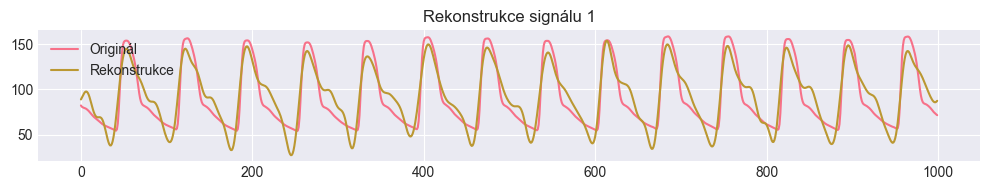

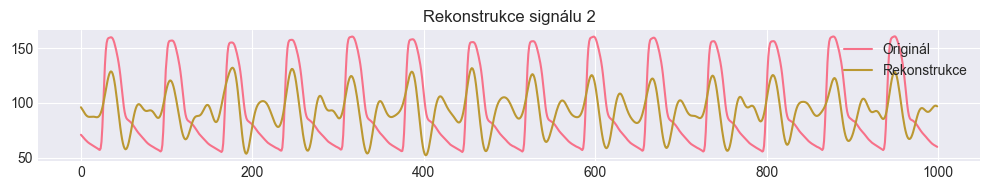

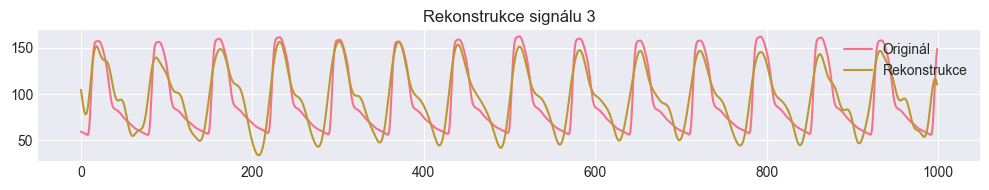

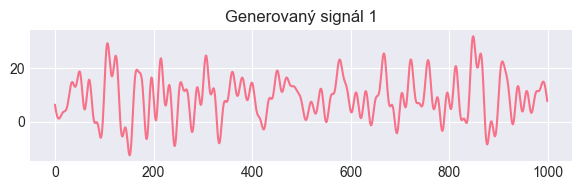

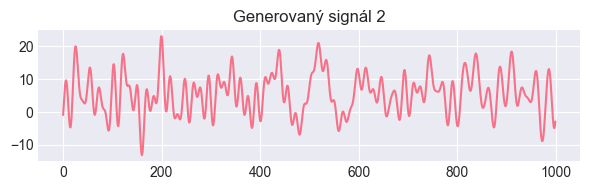

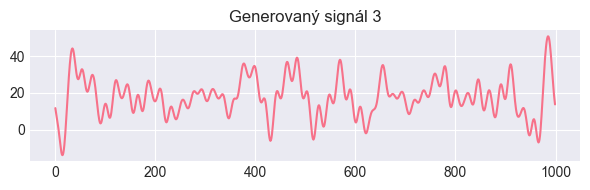

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.preprocessing import StandardScaler
import joblib
from lib.loader import FolderExtractor, SingleFileExtractor

HDF_PATH = "data"
SIGNAL_NAME = "art"
WINDOW_SIZE = 1000
N_COMPONENTS = 64
LATENT_DIM = 32
EPOCHS = 50
BATCH_SIZE = 32
BETA = 1e-3
MODEL_DIR = "models"
SCALER_PATH = os.path.join(MODEL_DIR, "rfft_scaler.pkl")
os.makedirs(MODEL_DIR, exist_ok=True)

def get_file_paths(folder_path):
    return [e._hdf5_file_path for e in FolderExtractor(folder_path)._extractors]

def load_signal(file_path, annotations_path, signal_name="art"):
    extractor = SingleFileExtractor(file_path)
    extractor.auto_annotate(annotations_path)
    segments, _ = extractor.extract(signal_name)
    extractor.load_data(segments)
    clean = [s.data for s in segments if not s.anomalous and s.data is not None]
    return np.concatenate(clean) if clean else np.array([])

def compute_rfft_spectra(signal, window_size, n_components):
    spectra, originals = [], []
    for i in range(0, len(signal) - window_size + 1, window_size):
        window = signal[i:i + window_size]
        if not np.isnan(window).any():
            fft_vals = np.fft.rfft(window)
            fft_cut = fft_vals[:n_components]
            spectrum = np.stack([fft_cut.real, fft_cut.imag], axis=-1)
            spectra.append(spectrum)
            originals.append(window)
    return np.array(spectra), np.array(originals)

spectra_list, originals_list = [], []
for path in get_file_paths(HDF_PATH):
    signal = load_signal(path, HDF_PATH, SIGNAL_NAME)
    if signal.size == 0:
        continue
    spec, orig = compute_rfft_spectra(signal, WINDOW_SIZE, N_COMPONENTS)
    spectra_list.append(spec)
    originals_list.append(orig)

X = np.vstack(spectra_list)
originals = np.vstack(originals_list)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, 2)).reshape(X.shape)
joblib.dump(scaler, SCALER_PATH)

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_encoder(input_shape, latent_dim):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(32, 3, padding="same", activation="relu", kernel_initializer="he_normal")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(16, 3, padding="same", activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv1D(8, 3, padding="same", activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu")(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    z = Sampling()([z_mean, z_log_var])
    return Model(inputs, [z_mean, z_log_var, z], name="encoder")

def build_decoder(latent_dim, output_shape):
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(64, activation="relu")(inputs)
    x = layers.Dense(np.prod(output_shape), activation="linear")(x)
    x = layers.Reshape(output_shape)(x)
    x = layers.Conv1D(8, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(16, 3, padding="same", activation="relu")(x)
    x = layers.Conv1D(output_shape[-1], 3, padding="same", activation="linear")(x)
    return Model(inputs, x, name="decoder")

class VAE(Model):
    def __init__(self, encoder, decoder, beta=1e-3):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer

    def train_step(self, data):
        if isinstance(data, tuple): data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            recon = self.decoder(z)
            loss_recon = tf.reduce_mean(tf.square(data - recon))
            loss_kl = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            loss_total = loss_recon + self.beta * loss_kl
        grads = tape.gradient(loss_total, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(loss_total)
        self.recon_loss_tracker.update_state(loss_recon)
        self.kl_loss_tracker.update_state(loss_kl)
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

encoder = build_encoder((N_COMPONENTS, 2), LATENT_DIM)
decoder = build_decoder(LATENT_DIM, (N_COMPONENTS, 2))
vae = VAE(encoder, decoder, beta=BETA)
vae.compile(optimizer=tf.keras.optimizers.Adam(1e-4))
vae.fit(X_scaled, epochs=EPOCHS, batch_size=BATCH_SIZE)

encoder.save(os.path.join(MODEL_DIR, "vae_encoder_rfft.keras"))
decoder.save(os.path.join(MODEL_DIR, "vae_decoder_rfft.keras"))

reconstructed = vae.decoder(vae.encoder(X_scaled)[2]).numpy()
reconstructed = scaler.inverse_transform(reconstructed.reshape(-1, 2)).reshape(reconstructed.shape)

for i in range(3):
    re = reconstructed[i][:, 0]
    im = reconstructed[i][:, 1]
    spectrum = re + 1j * im
    recon_time = np.fft.irfft(spectrum, n=WINDOW_SIZE)
    plt.figure(figsize=(10, 2))
    plt.plot(originals[i], label="Originál")
    plt.plot(recon_time, label="Rekonstrukce")
    plt.title(f"Rekonstrukce signálu {i+1}")
    plt.legend()
    plt.tight_layout()
    plt.show()

random_latents = tf.random.normal((3, LATENT_DIM))
generated = decoder(random_latents).numpy()
generated = scaler.inverse_transform(generated.reshape(-1, 2)).reshape(generated.shape)

for i in range(3):
    re = generated[i][:, 0]
    im = generated[i][:, 1]
    spectrum = re + 1j * im
    gen_time = np.fft.irfft(spectrum, n=WINDOW_SIZE)
    plt.figure(figsize=(6, 2))
    plt.plot(gen_time)
    plt.title(f"Generovaný signál {i+1}")
    plt.tight_layout()
    plt.show()


Epoch 1/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - kl_loss: 5.7050 - loss: 0.6459 - recon_loss: 0.6402
Epoch 2/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - kl_loss: 11.4806 - loss: 0.2319 - recon_loss: 0.2205
Epoch 3/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - kl_loss: 10.3352 - loss: 0.1627 - recon_loss: 0.1524
Epoch 4/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - kl_loss: 8.9941 - loss: 0.1283 - recon_loss: 0.1193
Epoch 5/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - kl_loss: 8.2056 - loss: 0.1097 - recon_loss: 0.1015
Epoch 6/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - kl_loss: 7.3116 - loss: 0.0996 - recon_loss: 0.0923
Epoch 7/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - kl_loss: 6.6359 - loss: 0.0946 - recon_loss: 0.0880
Epoch 8/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - kl_loss: 6.1197 - loss: 0.0905 - recon_loss: 0.0844
Epoch 9/100
974/974 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - kl_loss: 5.7680 - loss: 0.0884 - recon_loss: 0.0826
Epoch 10/100
974/974 ━━━━━━━━━━━━━━

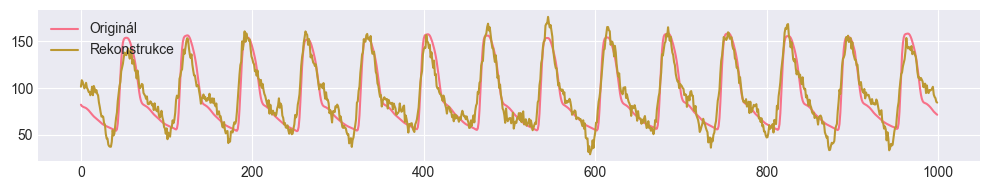

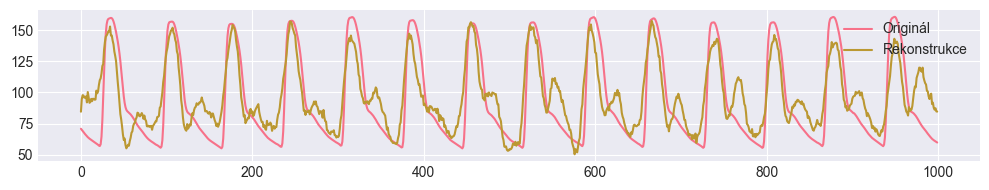

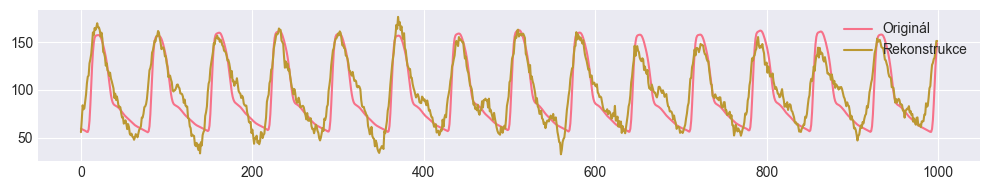

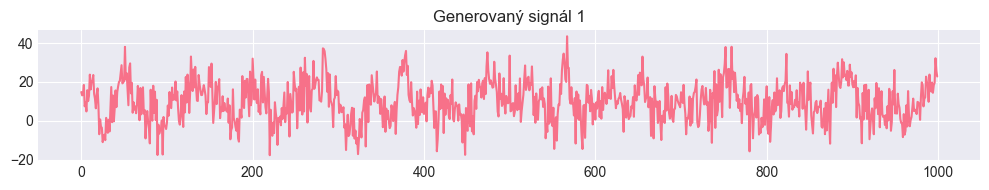

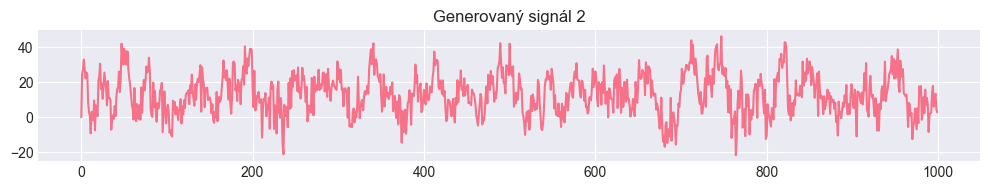

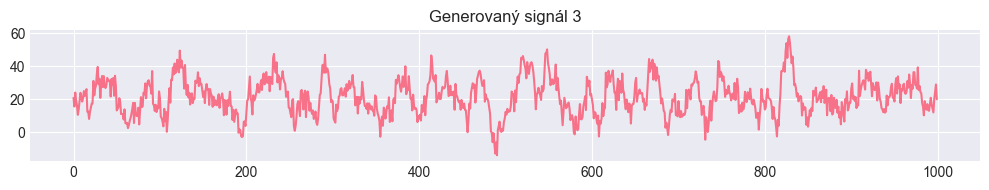

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.preprocessing import StandardScaler
import joblib
from lib.loader import FolderExtractor, SingleFileExtractor

HDF_PATH = "data"
SIGNAL_NAME = "art"
WINDOW_SIZE = 1000
N_COMPONENTS = WINDOW_SIZE // 2 + 1  # plné spektrum
LATENT_DIM = 32
EPOCHS = 100
BATCH_SIZE = 32
BETA = 1e-3
MODEL_DIR = "models"
SCALER_PATH = os.path.join(MODEL_DIR, "rfft_scaler.pkl")
os.makedirs(MODEL_DIR, exist_ok=True)

def get_file_paths(folder_path):
    return [e._hdf5_file_path for e in FolderExtractor(folder_path)._extractors]

def load_signal(file_path, annotations_path, signal_name="art"):
    extractor = SingleFileExtractor(file_path)
    extractor.auto_annotate(annotations_path)
    segments, _ = extractor.extract(signal_name)
    extractor.load_data(segments)
    clean = [s.data for s in segments if not s.anomalous and s.data is not None]
    return np.concatenate(clean) if clean else np.array([])

def compute_rfft_spectra(signal, window_size):
    spectra, originals = [], []
    for i in range(0, len(signal) - window_size + 1, window_size):
        window = signal[i:i + window_size]
        if not np.isnan(window).any():
            fft_vals = np.fft.rfft(window)
            spectrum = np.stack([fft_vals.real, fft_vals.imag], axis=-1)
            spectra.append(spectrum)
            originals.append(window)
    return np.array(spectra), np.array(originals)

spectra_list, originals_list = [], []
for path in get_file_paths(HDF_PATH):
    signal = load_signal(path, HDF_PATH, SIGNAL_NAME)
    if signal.size == 0:
        continue
    spec, orig = compute_rfft_spectra(signal, WINDOW_SIZE)
    spectra_list.append(spec)
    originals_list.append(orig)

X = np.vstack(spectra_list)
originals = np.vstack(originals_list)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, 2)).reshape(X.shape)
joblib.dump(scaler, SCALER_PATH)

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_encoder(input_shape, latent_dim):
    inputs = layers.Input(shape=input_shape)
    x = layers.Flatten()(inputs)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    z = Sampling()([z_mean, z_log_var])
    return Model(inputs, [z_mean, z_log_var, z], name="encoder")

def build_decoder(latent_dim, output_shape):
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(128, activation="relu")(inputs)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(np.prod(output_shape), activation="linear")(x)
    outputs = layers.Reshape(output_shape)(x)
    return Model(inputs, outputs, name="decoder")

class VAE(Model):
    def __init__(self, encoder, decoder, beta=1e-3):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer

    def train_step(self, data):
        if isinstance(data, tuple): data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            recon = self.decoder(z)
            loss_recon = tf.reduce_mean(tf.square(data - recon))
            loss_kl = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            loss_total = loss_recon + self.beta * loss_kl
        grads = tape.gradient(loss_total, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(loss_total)
        self.recon_loss_tracker.update_state(loss_recon)
        self.kl_loss_tracker.update_state(loss_kl)
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

encoder = build_encoder((N_COMPONENTS, 2), LATENT_DIM)
decoder = build_decoder(LATENT_DIM, (N_COMPONENTS, 2))
vae = VAE(encoder, decoder, beta=BETA)
vae.compile(optimizer=tf.keras.optimizers.Adam(1e-4))
vae.fit(X_scaled, epochs=EPOCHS, batch_size=BATCH_SIZE)

encoder.save(os.path.join(MODEL_DIR, "vae_encoder_rfft.keras"))
decoder.save(os.path.join(MODEL_DIR, "vae_decoder_rfft.keras"))

reconstructed = vae.decoder(vae.encoder(X_scaled)[2]).numpy()
reconstructed = scaler.inverse_transform(reconstructed.reshape(-1, 2)).reshape(reconstructed.shape)

for i in range(3):
    spectrum = reconstructed[i][:, 0] + 1j * reconstructed[i][:, 1]
    recon_time = np.fft.irfft(spectrum, n=WINDOW_SIZE)
    plt.figure(figsize=(10, 2))
    plt.plot(originals[i], label="Originál")
    plt.plot(recon_time, label="Rekonstrukce")
    plt.legend()
    plt.tight_layout()
    plt.show()

random_latents = tf.random.normal((3, LATENT_DIM))
generated = decoder(random_latents).numpy()
generated = scaler.inverse_transform(generated.reshape(-1, 2)).reshape(generated.shape)

for i in range(3):
    spectrum = generated[i][:, 0] + 1j * generated[i][:, 1]
    gen_time = np.fft.irfft(spectrum, n=WINDOW_SIZE)
    plt.figure(figsize=(10, 2))
    plt.plot(gen_time)
    plt.title(f"Generovaný signál {i+1}")
    plt.tight_layout()
    plt.show()

Loading data from: data
Processing file: data\signals_2024-03-04\dataset_0\TBI_001_v2_1_2_20.hdf5
Processing file: data\signals_2024-03-04\dataset_0\TBI_001_v2_1_3_6.hdf5
Processing file: data\signals_2024-03-04\dataset_0\TBI_002_v4_2_5_5.hdf5
Processing file: data\signals_2024-03-04\dataset_0\TBI_002_v4_2_7_8.hdf5
Processing file: data\signals_2024-03-04\dataset_0\TBI_003_v2_2_1_0.hdf5
Processing file: data\signals_2024-03-04\dataset_0\TBI_003_v2_2_1_5.hdf5
Processing file: data\signals_2024-03-04\dataset_0\TBI_004b_v2_1_2_16.hdf5
Processing file: data\signals_2024-03-04\dataset_0\TBI_004b_v2_1_3_6.hdf5
Processing file: data\signals_2024-03-04\dataset_0\TBI_005_v2_2_2_19.hdf5
Processing file: data\signals_2024-03-04\dataset_0\TBI_007_v3_1_2_17.hdf5
Processing file: data\signals_2024-03-04\dataset_1\TBI_001_v2_1_2_5.hdf5
Processing file: data\signals_2024-03-04\dataset_1\TBI_002_v4_2_5_20.hdf5
Processing file: data\signals_2024-03-04\dataset_1\TBI_002_v4_2_7_6.hdf5
Processing file: dat

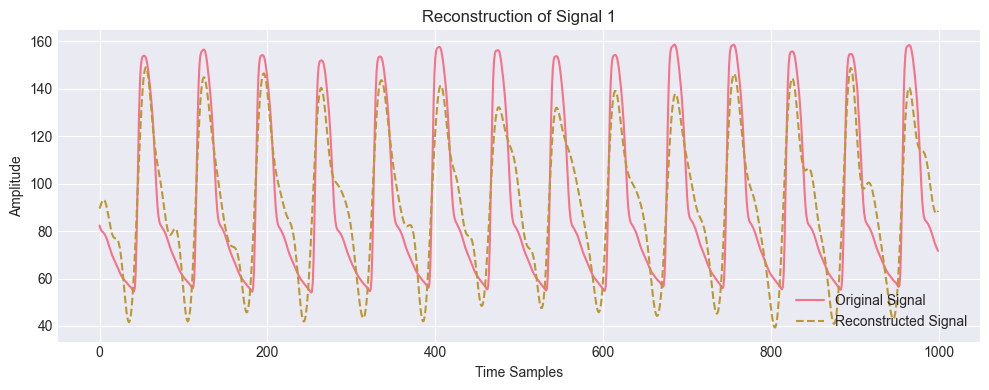

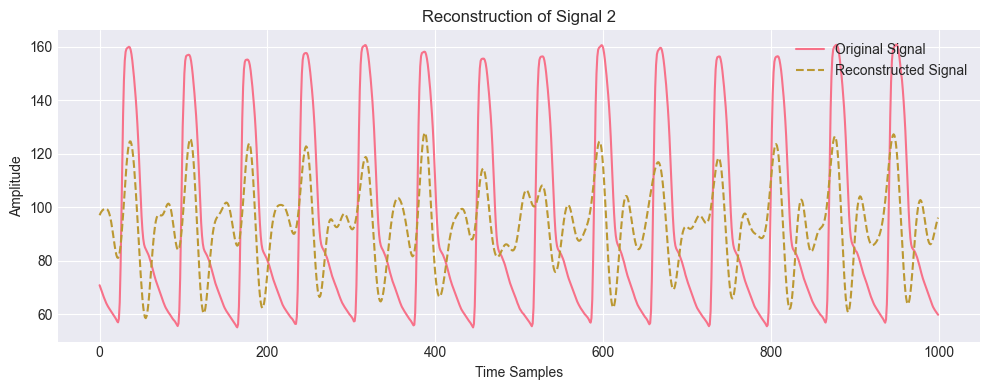

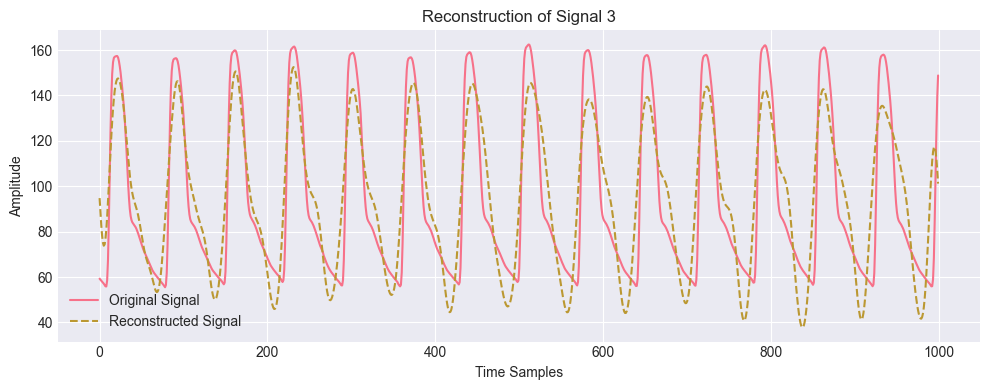


--- Generating New Samples ---


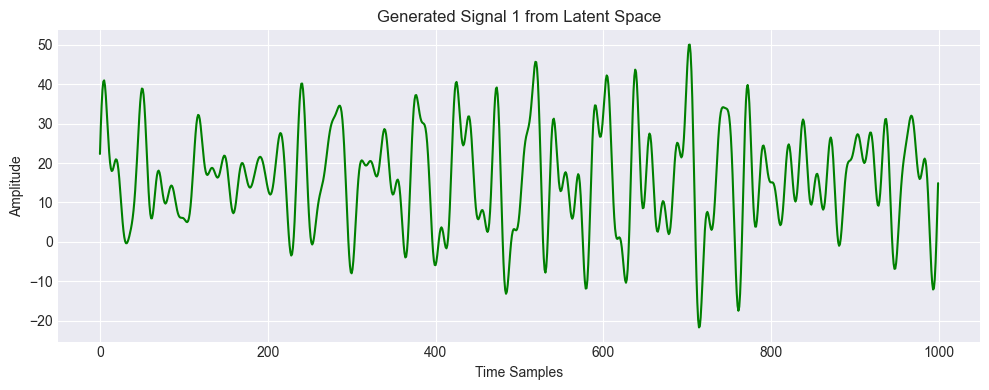

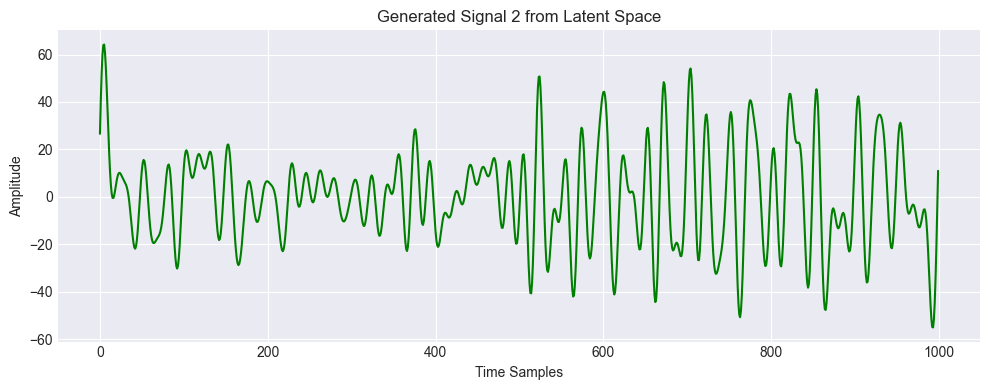

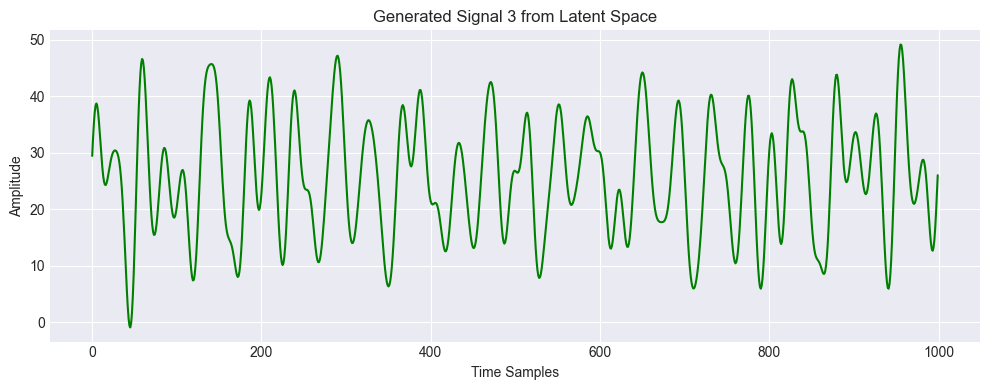


--- Script Finished ---


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.preprocessing import StandardScaler
import joblib

from lib.loader import FolderExtractor, SingleFileExtractor

HDF_PATH = "data"
SIGNAL_NAME = "art"
WINDOW_SIZE = 1000
N_COMPONENTS = 64
LATENT_DIM = 32
EPOCHS = 100
BATCH_SIZE = 64
BETA = 5e-4
MODEL_DIR = "models"
SCALER_PATH = os.path.join(MODEL_DIR, "rfft_scaler.pkl")

os.makedirs(MODEL_DIR, exist_ok=True)

def get_file_paths(folder_path):
    """
    Retrieves HDF5 file paths from a given folder using FolderExtractor.
    """
    return [e._hdf5_file_path for e in FolderExtractor(folder_path)._extractors]

def load_signal(file_path, annotations_path, signal_name="art"):
    """
    Loads a specific signal from an HDF5 file, auto-annotates it,
    and extracts clean segments.
    """
    extractor = SingleFileExtractor(file_path)
    extractor.auto_annotate(annotations_path)
    segments, _ = extractor.extract(signal_name)
    extractor.load_data(segments)
    clean = [s.data for s in segments if not s.anomalous and s.data is not None]
    return np.concatenate(clean) if clean else np.array([])

def compute_rfft_spectra(signal, window_size, n_components):
    """
    Computes Real Fast Fourier Transform (RFFT) spectra from a signal
    in non-overlapping windows.
    """
    spectra, originals = [], []
    for i in range(0, len(signal) - window_size + 1, window_size):
        window = signal[i : i + window_size]
        if not np.isnan(window).any():
            fft_vals = np.fft.rfft(window)
            fft_cut = fft_vals[:n_components]
            spectrum = np.stack([fft_cut.real, fft_cut.imag], axis=-1)
            spectra.append(spectrum)
            originals.append(window)
    return np.array(spectra), np.array(originals)

spectra_list, originals_list = [], []
print(f"Loading data from: {HDF_PATH}")
for path in get_file_paths(HDF_PATH):
    print(f"Processing file: {path}")
    signal = load_signal(path, HDF_PATH, SIGNAL_NAME)
    if signal.size == 0:
        print(f"No clean signal found in {path}. Skipping.")
        continue
    spec, orig = compute_rfft_spectra(signal, WINDOW_SIZE, N_COMPONENTS)
    if spec.size == 0:
        print(f"No valid spectra generated for {path}. Skipping.")
        continue
    spectra_list.append(spec)
    originals_list.append(orig)

if not spectra_list:
    raise ValueError("No data was loaded or processed. Please check your HDF_PATH and data files.")

X = np.vstack(spectra_list)
originals = np.vstack(originals_list)

print(f"Shape of raw spectra (X): {X.shape}")
print(f"Shape of original windows: {originals.shape}")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(-1, 2)).reshape(X.shape)
joblib.dump(scaler, SCALER_PATH)
print(f"Scaler saved to: {SCALER_PATH}")
print(f"Shape of scaled spectra (X_scaled): {X_scaled.shape}")

class Sampling(layers.Layer):
    """
    Custom Keras layer for sampling from the latent space using the
    reparameterization trick.
    """
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_encoder(input_shape, latent_dim):
    """
    Builds the encoder part of the VAE with increased capacity.
    """
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(32, 3, padding="same")(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv1D(16, 3, padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv1D(8, 3, padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling(name="z")([z_mean, z_log_var])
    return Model(inputs, [z_mean, z_log_var, z], name="encoder")

def build_decoder(latent_dim, output_shape):
    """
    Builds the decoder part of the VAE with increased capacity.
    """
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(64)(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dense(np.prod(output_shape))(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Reshape(output_shape)(x)

    x = layers.Conv1D(64, 3, padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv1D(32, 3, padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv1D(16, 3, padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    outputs = layers.Conv1D(output_shape[-1], 3, padding="same", activation="linear")(x)
    return Model(inputs, outputs, name="decoder")

class VAE(Model):
    """
    Variational Autoencoder (VAE) model with Huber loss for reconstruction.
    """
    def __init__(self, encoder, decoder, beta=1e-3, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        # Použití Huberovy ztráty místo MSE pro rekonstrukci
        self.recon_loss_fn = tf.keras.losses.Huber(delta=1.0, reduction=tf.keras.losses.Reduction.NONE)
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.recon_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            recon = self.decoder(z)
            # Výpočet Huberovy ztráty
            loss_recon = tf.reduce_mean(self.recon_loss_fn(data, recon))
            loss_kl = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )
            loss_total = loss_recon + self.beta * loss_kl

        grads = tape.gradient(loss_total, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(loss_total)
        self.recon_loss_tracker.update_state(loss_recon)
        self.kl_loss_tracker.update_state(loss_kl)

        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

print("\n--- Starting VAE Training ---")
encoder = build_encoder((N_COMPONENTS, 2), LATENT_DIM)
decoder = build_decoder(LATENT_DIM, (N_COMPONENTS, 2))
vae = VAE(encoder, decoder, beta=BETA)
vae.compile(optimizer=tf.keras.optimizers.Adam(1e-4))
vae.fit(X_scaled, epochs=EPOCHS, batch_size=BATCH_SIZE)

encoder_save_path = os.path.join(MODEL_DIR, "vae_encoder_rfft.keras")
decoder_save_path = os.path.join(MODEL_DIR, "vae_decoder_rfft.keras")
encoder.save(encoder_save_path)
decoder.save(decoder_save_path)
print(f"Encoder saved to: {encoder_save_path}")
print(f"Decoder saved to: {decoder_save_path}")

print("\n--- Reconstructing Samples ---")
# Získání latentní reprezentace a rekonstrukce
_, _, z_reconstructed = vae.encoder(X_scaled)
reconstructed_spectra = vae.decoder(z_reconstructed).numpy()
reconstructed_spectra = scaler.inverse_transform(
    reconstructed_spectra.reshape(-1, 2)
).reshape(reconstructed_spectra.shape)

for i in range(3):
    re_recon = reconstructed_spectra[i][:, 0]
    im_recon = reconstructed_spectra[i][:, 1]
    spectrum_recon = re_recon + 1j * im_recon
    recon_time = np.fft.irfft(spectrum_recon, n=WINDOW_SIZE)

    plt.figure(figsize=(10, 4))
    plt.plot(originals[i], label="Original Signal")
    plt.plot(recon_time, label="Reconstructed Signal", linestyle='--')
    plt.title(f"Reconstruction of Signal {i+1}")
    plt.xlabel("Time Samples")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print("\n--- Generating New Samples ---")
# Generování náhodných latentních vektorů a dekódování
random_latents = tf.random.normal((3, LATENT_DIM))
generated_spectra = decoder(random_latents).numpy()
# Inverzní transformace generovaného spektra
generated_spectra = scaler.inverse_transform(
    generated_spectra.reshape(-1, 2)
).reshape(generated_spectra.shape)

for i in range(3):
    re_gen = generated_spectra[i][:, 0]
    im_gen = generated_spectra[i][:, 1]
    spectrum_gen = re_gen + 1j * im_gen
    gen_time = np.fft.irfft(spectrum_gen, n=WINDOW_SIZE)

    plt.figure(figsize=(10, 4))
    plt.plot(gen_time, color='green')
    plt.title(f"Generated Signal {i+1} from Latent Space")
    plt.xlabel("Time Samples")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print("\n--- Script Finished ---")